In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
import xgboost 
from matplotlib import pyplot
from sklearn import set_config
set_config(transform_output="pandas")


In [2]:
data_path = "Dataset_analyse.csv"
df = pd.read_csv(data_path)

df = df.drop(['month','month_name','raw_title','actor_list','budget','total_actor_scores','rating_press','day',"total_spectator",'distributor','classification_country','country','director',"hebdo_rank","first_day","first_weekend","casting","award","lang"], axis=1)
df = df.dropna()

df

,year,duration,genre,first_week,copies,director_combined_score,entree_annee,distributor_combined_score,year_combined_score,country_combined_score,season,is_holiday
0,2008,6360,comedie,4378720,793,0.537844,190.3,0.707143,0.830920,0.718586,winter,0
1,2006,5820,comedie,3906694,950,0.288597,188.8,0.593832,0.855770,0.718586,winter,0
2,2000,5400,comedie,3478850,831,0.447876,165.8,0.541686,0.758796,0.718586,spring,0
3,2005,8760,fantasy,3303005,938,0.564055,175.6,0.518926,0.816782,0.917933,spring,0
4,2019,7080,aventure action,3252896,680,0.348963,213.2,0.489794,0.826926,0.917933,summer,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2665,2010,5580,thriller,48033,93,0.131239,207.1,0.050279,0.763881,0.718586,autumn,0
2666,2003,6960,drame,47922,-1,0.167568,173.5,0.028472,0.710492,0.718586,winter,0
2667,2013,8460,comedie dramatique,47900,81,0.181678,193.7,0.048923,0.818377,0.340714,spring,0
2668,2011,6060,drame,47715,170,0.133003,217.2,0.067727,0.881333,0.718586,summer,0


In [3]:
X = df.drop(['first_week'], axis=1)
y = df.first_week

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42)

num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)

onehotscale_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False), RobustScaler(with_centering=False))
scale_pipeline = make_pipeline(RobustScaler(with_centering=False))

preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', onehotscale_pipeline, cat_col),
        ('numerical', scale_pipeline, num_col)]
)

polyscale_pipeline = make_pipeline(PolynomialFeatures(2))

my_final_pipeline = make_pipeline(preprocessing)#, polyscale_pipeline)
my_final_pipeline.fit(X_train)

feature_names = my_final_pipeline.get_feature_names_out(X.columns)

In [4]:
# from sklearn import set_config


# set_config(transform_output="pandas")
# model = make_pipeline(
#     my_final_pipeline,
# )
# xdata = model.fit_transform(X_train, y_train)
# xdata.head()

In [5]:
model = make_pipeline(
    my_final_pipeline,
    xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    )

model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False)),
                                                                                   ('robustscaler',
                                                                                    RobustScaler(with_centering=False))]),
                                                                   ['genre',
                                                                    'season']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('robustscaler',
                                                                                    RobustScaler(with_centerin...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [6]:
# pyplot.bar(range(len(model[-1].feature_importances_)), model[-1].feature_importances_)
# pyplot.show()

In [7]:
xtrain_tr = model[:-1].fit_transform(X_train)

In [8]:
xtrain_tr.columns

Index(['categorical__genre_animation', 'categorical__genre_aventure action',
       'categorical__genre_catastrophe', 'categorical__genre_comedie',
       'categorical__genre_comedie dramatique', 'categorical__genre_comicbook',
       'categorical__genre_documentaire', 'categorical__genre_drame',
       'categorical__genre_fantasy', 'categorical__genre_film familial',
       'categorical__genre_guerre', 'categorical__genre_horreur',
       'categorical__genre_musical', 'categorical__genre_peplum',
       'categorical__genre_romance', 'categorical__genre_science fiction',
       'categorical__genre_thriller', 'categorical__genre_western',
       'categorical__season_autumn', 'categorical__season_spring',
       'categorical__season_summer', 'categorical__season_winter',
       'numerical__year', 'numerical__duration', 'numerical__copies',
       'numerical__director_combined_score', 'numerical__entree_annee',
       'numerical__distributor_combined_score',
       'numerical__year_combin

In [9]:
# pd.Series(model[-1].feature_importances_, index = xtrain_tr.columns)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

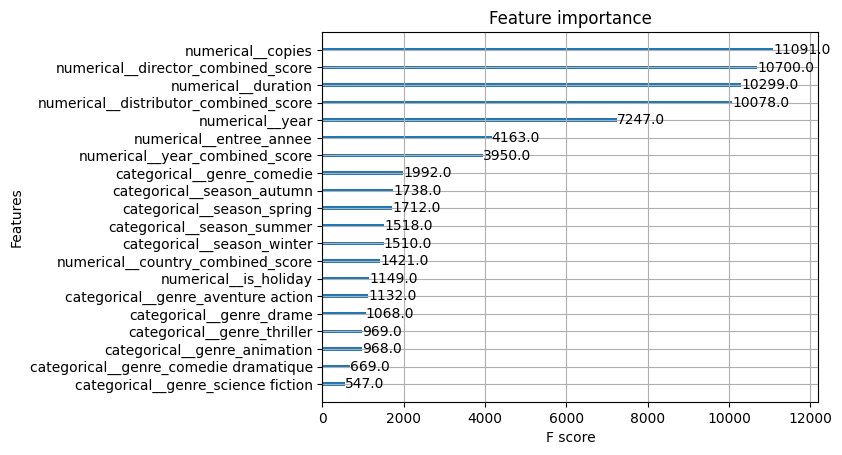

In [10]:
xgboost.plot_importance(model[-1], max_num_features=20)

In [11]:
# y_pred_train = model.predict(X_train)


# residus =  y_pred_train - y_train


# weights = np.exp(-abs(residus) / residus.std())
# model.fit(X_train, y_train, lasso__sample_weight=weights)




y_pred = model.predict(X_test)
# y_pred = model.predict(df_test)
# print(y_pred)

In [12]:

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

Performance du modèle :
R2 Score: 0.8557
MAE: 71995.87
RMSE: 148752.01


In [13]:
from joblib import dump, load

model_path = 'model.pkl'
dump(model, model_path)
model = load('model.pkl')

In [14]:
def predict_prod(model,data):
    # Convertir la liste de listes en DataFrame
    df = pd.DataFrame(data, columns=['year','season', 'entree_annee','is_holiday','month','day','director', 'country','classification_country','classification_acteurs' ,'duration', 'genre', 'copies', 'rating_press','budget','distributor'])
    predictions = model.predict(df)
    return predictions

predict_prod(model,[[2024,'spring', 180.8,1,3, 8,2, "etatsunis",3,3, 5640, "animation", 696, 3.4, 85000000, 3]])

ValueError: columns are missing: {'distributor_combined_score', 'year_combined_score', 'country_combined_score', 'director_combined_score'}